# Trouble Shooting this Notebook/Pyspark/Graphframes

- Main thing is to make sure that you are using the same pyspark and spark
- to check the versions of python packages that you are using run this command on windows command prompt or apple terminal:
- pip freeze
- Check the version of Python that you are using: Spark 3 and below will not work with python 3.6+
- When you pip install graphframes it will install with 0.60 of graph frames
- Go to this github and download spark 0.82 if you are using python 3.6+ / spark 3+
- https://github.com/graphframes/graphframes/releases/tag/v0.8.2
- Download the source files and then copy and paste the files from this file witin the files that you just downloaded
- C:\Users\deloitte_user_name\Downloads\graphframes-0.8.2\python\graphframes
- paste this files into where python stores its external packages. 
- if you are using jupyter notebooks/anaconda it will be here
- C:\Users\deloitte_user_name\Anaconda3\Lib\site-packages
- lastly download the correspond JAR file to the version of spark and graphframes that you are using at the site below
- https://spark-packages.org/package/graphframes/graphframes
- you are going to need to move this file into where you store the JAR files for spark
- for me this is : C:\Spark\spark\spark-3.1.1-bin-hadoop2.7\jars
- if you are still runnning into problems be sure to check you have your enviroment variables configured right/ have installed spark correctly
- I used this guide and it was useful: https://www.youtube.com/watch?v=cYL42BBL3Fo&t=147s


In [1]:
from pyspark.sql.functions import col, explode, year, month
from pyspark.sql import SparkSession
import findspark

In [2]:
findspark.init()

In [3]:

 #.config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest.jar') \
    #.config('spark.executor.cores', '3') \
    #.config('spark.executor.memory', '5g') \
    #.config("spark.sql.broadcastTimeout", "36000")\
    
#spark = SparkSession.builder.master('yarn').appName('ChainAnalysis_v0').getOrCreate()
#sc = spark.sparkContext

In [4]:
spark = spark = SparkSession.builder.master("local").appName("Test Spark").getOrCreate()
sc= spark.sparkContext

# Fraud Detection ML Section

In [5]:
import lightgbm as lgb
import optuna as op
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler as stdsc
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

df = pd.read_csv('Blockchain Competition Data.csv')
df

,Month,Day,Time,DayOfWeek,TransactionID,InputAddress,OutputAddress,BTC,Illicit
0,4,27,12:38:19,6,4b585ab8815f189d18922b1866cb4f86743f3d305f0316...,19WNHovTv17jAihMuj9wvmLzpKv6s9gHad,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,50.000000,0
1,12,5,20:35:41,5,081c88ecc74eab23318b7bddec8db4c78429573d4acd57...,3BXMABa8Yxcq9JvPEdizBdbZCvqbMMp6ao,3Qg6fRqQZuH8e2RRwcf6cMHrtkyEBEpfUX,0.002116,1
2,12,13,2:30:22,6,1835eb794ef4e3909f25d3f11f794a93ff5e2db84004b8...,1PZtVNDMzH4GjDjvzzJ6xNkMVshdqf6rbc,19iVyH1qUxgywY8LJSbpV4VavjZmyuEyxV,29.653250,1
3,12,5,14:55:39,5,cfa2d9e29726f0a0940204aab2ecd0e920d75867a73dc1...,1NzfRfu5Pc1PHBP13iFNkq8FEiSPCA1Dk6,15VkKWoCNqxnNAUFZzfSuhjkvw1L7CqgtA,0.000137,1
4,11,19,5:46:16,3,30098ef68574c7e727dab520e9623ee91e90625b937fca...,1Gw1CxCosujMQv8fgDfahctrtdcMmkyXZh,16oShVdj75jxmmEj66yGqYQNmTJhoCYQMw,2.426779,1
...,...,...,...,...,...,...,...,...,...
40820,11,25,11:43:19,1,8e530147a819941f715ebde2d4ce2fc3f89c411c9a18c7...,1BmMiNjbHgiahBrtcMjNwg8Urxv2VbrEvf,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,50.277000,0
40821,4,13,3:28:56,6,92e5192b5c34df327f4805999f4fa254a8fc93e6319c30...,1CYniGNxPuec1w9KCmRtZaDmaLCBWWYPD1,133K4dfRXbp2gpjBszm7U2y3sWMJa3xpAu,50.000000,0
40822,6,20,22:46:51,4,5bab77e462190c224fcda02348145d89187d7e52cc0213...,1Fnra5i6xBFmWVH5RXahat8TDtsk8Y6fpk,1NNEFF5HYW8tZAXNLoj298mLVR8qXJAjC3,0.472150,0
40823,7,30,3:52:38,2,8e0827a0c7039058be9870f4f28e8b24f22fe58eab64fc...,1B968tmP1VgKLueXhwTgiAg2AEEPwyHExz,13seCEjLFzDbnZxxH9KfFNHs5ETqdhfUYU,50.000000,0


In [6]:
df['Illicit'].value_counts()

0    27825
1    13000
Name: Illicit, dtype: int64

In [7]:
####Feature Engineering

#### Graph Features

In [8]:
import pandas as pd
kdf = df

In [9]:
%%time
unique_ids_list = kdf["InputAddress"].to_list() + kdf["OutputAddress"].to_list()
unique_ids_list = list(dict.fromkeys(unique_ids_list))
kdf["src"] = kdf['InputAddress'].apply(lambda x: unique_ids_list.index(x))
kdf["dst"] = kdf['OutputAddress'].apply(lambda x: unique_ids_list.index(x))

CPU times: total: 9.16 s
Wall time: 9.03 s


In [10]:
vertices = pd.DataFrame(unique_ids_list, columns = ['Unique_ID'])
vertices['id'] = vertices['Unique_ID'].index
vertices

,Unique_ID,id
0,19WNHovTv17jAihMuj9wvmLzpKv6s9gHad,0
1,3BXMABa8Yxcq9JvPEdizBdbZCvqbMMp6ao,1
2,1PZtVNDMzH4GjDjvzzJ6xNkMVshdqf6rbc,2
3,1NzfRfu5Pc1PHBP13iFNkq8FEiSPCA1Dk6,3
4,1Gw1CxCosujMQv8fgDfahctrtdcMmkyXZh,4
...,...,...
35234,161o3vQg6wWmnb8LeEkqhuxtte5uFdjmQy,35234
35235,3AqBUd57txxxdf1ocsjnfNeUjNYaNYmmPm,35235
35236,16gypkSY2f3t3QzMZqLm8uEtFEP3k5eQwB,35236
35237,3LHbo7N2bCZPXNcwc8JvaBwgTznGkUeB3d,35237


In [11]:
# kdf

In [12]:
#Load data into graphframes for spark feature engineering using graph created
from graphframes import *
vertices_sdf = spark.createDataFrame(vertices)
edges_sdf = spark.createDataFrame(kdf[['src','dst']])
g = GraphFrame(vertices_sdf, edges_sdf)

In [13]:
g.vertices.show()
g.edges.show()

+--------------------+---+
|           Unique_ID| id|
+--------------------+---+
|19WNHovTv17jAihMu...|  0|
|3BXMABa8Yxcq9JvPE...|  1|
|1PZtVNDMzH4GjDjvz...|  2|
|1NzfRfu5Pc1PHBP13...|  3|
|1Gw1CxCosujMQv8fg...|  4|
|14zKfi2gc77Aswr1E...|  5|
|15h6wBZbQv1Nv3peY...|  6|
|1NtJj5tMLqdhzWV6S...|  7|
|1AuJBLYtsQxUeiuG3...|  8|
|1HktqScAwkTPpmtyJ...|  9|
|14JJG9HH75YrybPf5...| 10|
|1BoqXQsg5pdVX3xSs...| 11|
|1EoAmuLBeLC2YpRAF...| 12|
|1HXTkmCMS9qYSHxmz...| 13|
|33vfdbfzbqiUAbH4k...| 14|
|1yW1yFH2GMoTFv7ZV...| 15|
|1ExzXxfkxfDbYJ5L9...| 16|
|1DgDJSsX5fPWEdzu1...| 17|
|1GkHhmaYmwHXYWnKG...| 18|
|3Bj2jVXAdkdCiPgnG...| 19|
+--------------------+---+
only showing top 20 rows

+---+-----+
|src|  dst|
+---+-----+
|  0|  234|
|  1| 3197|
|  2|  353|
|  3|23216|
|  4|17267|
|  5|  234|
|  6|  234|
|  7|  234|
|  8|  674|
|  9|23217|
| 10|23218|
| 11|  234|
| 12|23219|
| 13|23220|
| 14|23221|
| 15|  234|
| 16|23222|
| 17|  234|
| 18|  674|
| 19| 5085|
+---+-----+
only showing top 20 rows



In [14]:
g.vertices

DataFrame[Unique_ID: string, id: bigint]

In [15]:
vertices_df = g.vertices

def features(input_graph,vdf):
    results_pr = input_graph.pageRank(resetProbability=0.15, maxIter= 5)#, tol=0.01)
    df_pr = results_pr.vertices
    df_g = input_graph.degrees
    df_in = input_graph.inDegrees
    df_out = input_graph.outDegrees
    df_tr = input_graph.triangleCount()
    communities = input_graph.labelPropagation(maxIter=5)
    
    data = vdf.join(df_g, on=['id'],how='left')
    data = data.join(df_in, on=['id'],how='left')
    data = data.join(df_out, on=['id'],how='left')
    data = data.join(df_pr, on=['id','Unique_ID'],how='left')
    data = data.join(df_tr, on=['id', 'Unique_ID'],how='left')
    data = data.join(communities, on=['id', 'Unique_ID'],how='left')

    return data

features(g,vertices_df).show()

+----+--------------------+------+--------+---------+-------------------+-----+-----+
|  id|           Unique_ID|degree|inDegree|outDegree|           pagerank|count|label|
+----+--------------------+------+--------+---------+-------------------+-----+-----+
| 429|35c9y89b3QiY48sfs...|     1|    null|        1|0.45061549784683985|    0|23399|
|1271|1PyMTMjV3KTn7wFMz...|     1|    null|        1|0.45061549784683985|    0|  234|
|1650|16RBExMKpEpTFWKZS...|     2|    null|        2|0.45061549784683985|    0|24007|
|2130|15UG9rBZSNJGKWrJv...|     2|    null|        2|0.45061549784683985|    0|24252|
|2183|1NdppVU8tHqYXBBHB...|     1|    null|        1|0.45061549784683985|    0|  234|
|2335|1MT4C2E245mXP2qnJ...|     1|    null|        1|0.45061549784683985|    0|  234|
|2535|1LsT4tLFHfLzsRNKj...|    20|      12|        8|  4.280847229544977|    0|  782|
|2757|1M7axpvX9M8Gz6N12...|     2|    null|        2|0.45061549784683985|    0|24576|
|2893|3KQrqzPBSJrfS99Yb...|     1|    null|        1|0

In [16]:
g.vertices.count()

35239

#### Temporal Features

In [17]:
df_features = df 

In [18]:
df_features

,Month,Day,Time,DayOfWeek,TransactionID,InputAddress,OutputAddress,BTC,Illicit,src,dst
0,4,27,12:38:19,6,4b585ab8815f189d18922b1866cb4f86743f3d305f0316...,19WNHovTv17jAihMuj9wvmLzpKv6s9gHad,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,50.000000,0,0,234
1,12,5,20:35:41,5,081c88ecc74eab23318b7bddec8db4c78429573d4acd57...,3BXMABa8Yxcq9JvPEdizBdbZCvqbMMp6ao,3Qg6fRqQZuH8e2RRwcf6cMHrtkyEBEpfUX,0.002116,1,1,3197
2,12,13,2:30:22,6,1835eb794ef4e3909f25d3f11f794a93ff5e2db84004b8...,1PZtVNDMzH4GjDjvzzJ6xNkMVshdqf6rbc,19iVyH1qUxgywY8LJSbpV4VavjZmyuEyxV,29.653250,1,2,353
3,12,5,14:55:39,5,cfa2d9e29726f0a0940204aab2ecd0e920d75867a73dc1...,1NzfRfu5Pc1PHBP13iFNkq8FEiSPCA1Dk6,15VkKWoCNqxnNAUFZzfSuhjkvw1L7CqgtA,0.000137,1,3,23216
4,11,19,5:46:16,3,30098ef68574c7e727dab520e9623ee91e90625b937fca...,1Gw1CxCosujMQv8fgDfahctrtdcMmkyXZh,16oShVdj75jxmmEj66yGqYQNmTJhoCYQMw,2.426779,1,4,17267
...,...,...,...,...,...,...,...,...,...,...,...
40820,11,25,11:43:19,1,8e530147a819941f715ebde2d4ce2fc3f89c411c9a18c7...,1BmMiNjbHgiahBrtcMjNwg8Urxv2VbrEvf,1VayNert3x1KzbpzMGt2qdqrAThiRovi8,50.277000,0,23215,234
40821,4,13,3:28:56,6,92e5192b5c34df327f4805999f4fa254a8fc93e6319c30...,1CYniGNxPuec1w9KCmRtZaDmaLCBWWYPD1,133K4dfRXbp2gpjBszm7U2y3sWMJa3xpAu,50.000000,0,19454,23236
40822,6,20,22:46:51,4,5bab77e462190c224fcda02348145d89187d7e52cc0213...,1Fnra5i6xBFmWVH5RXahat8TDtsk8Y6fpk,1NNEFF5HYW8tZAXNLoj298mLVR8qXJAjC3,0.472150,0,13182,35238
40823,7,30,3:52:38,2,8e0827a0c7039058be9870f4f28e8b24f22fe58eab64fc...,1B968tmP1VgKLueXhwTgiAg2AEEPwyHExz,13seCEjLFzDbnZxxH9KfFNHs5ETqdhfUYU,50.000000,0,12421,23220


In [19]:
#df_features['transactionDateTime'] = pd.to_datetime(df_features['time'])
#df_features['transactionMonth'] = pd.to_datetime(df_features['transactionDateTime']).dt.month
#df_features['transactionDayOfWeek'] = pd.to_datetime(df_features['transactionDateTime']).dt.dayofweek
#df_features['transactionYear'] = pd.to_datetime(df_features['transactionDateTime']).dt.year
#df_features['transactionHour'] = pd.to_datetime(df_features['transactionDateTime']).dt.hour

In [20]:
df_features.sort_values(['InputAddress', 'Month','Day', 'Time'], inplace=True)
df_features.reset_index(inplace=True,drop=True)
df_features['inputMax'] = df_features.groupby('InputAddress')['BTC'].cummax()
df_features['inputMin'] = df_features.groupby('InputAddress')['BTC'].cummin()
df_features['inputSum'] = df_features.groupby('InputAddress')['BTC'].cumsum()
df_features.sort_values(['OutputAddress', 'Month','Day', 'Time'], inplace=True)
df_features.reset_index(inplace=True,drop=True)
df_features['outputMax'] = df_features.groupby('OutputAddress')['BTC'].cummax()
df_features['outputMin'] = df_features.groupby('OutputAddress')['BTC'].cummin()
df_features['outputSum'] = df_features.groupby('OutputAddress')['BTC'].cumsum()

In [21]:
#df_features.sort_values(['InputAddress', 'Month','Day', 'Time'], inplace=True)
#df_features.reset_index(inplace=True,drop=True)
#df_features['Duration_Inputs'] = (df_features['transactionDateTime'] - df_features.groupby('input_address')['transactionDateTime'].cummin()).dt.days

#df_features.sort_values(['output_address', 'transactionDateTime'], inplace=True)
#df_features.reset_index(inplace=True,drop=True)
#df_features['Duration_Outputs'] = (df_features['transactionDateTime'] - df_features.groupby('output_address')['transactionDateTime'].cummin()).dt.days


In [22]:
df_final = df_features
df_final.head(5)

,Month,Day,Time,DayOfWeek,TransactionID,InputAddress,OutputAddress,BTC,Illicit,src,dst,inputMax,inputMin,inputSum,outputMax,outputMin,outputSum
0,7,4,12:04:48,4,0db73422520423519b152bc44824c61faf84088e0bf385...,17Su3J2RWnm2WLqf8pfpgj4hFUf6MFH9SZ,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,0.100000,0,263,24076,200.000000,0.100000,1237.246977,0.100000,0.100000,0.100000
1,7,4,12:04:48,4,0db73422520423519b152bc44824c61faf84088e0bf385...,1K4jCTyKSkATCXB6sXAwN3nkyvQveRMqPZ,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,0.100000,0,741,24076,84.705376,0.100000,694.136401,0.100000,0.100000,0.200000
2,4,16,8:25:51,2,c802582a0acb3c66caa06ce4e767413086a713c732c893...,14aydKbSbRacakgoYzwFkdbLeirJHruiNc,112AYM2ubn4hEdJjb5NGguuEEo6Snp7oBK,0.015600,0,16319,31397,0.015600,0.015600,0.015600,0.015600,0.015600,0.015600
3,11,17,14:24:11,1,6ce024cf19da1ea2d07be757ac87f1edb9e926bd1e76fa...,12szbegicLBGAKaYKDEkxm4WHSV9v1jp5J,112JKu613am7FqJyxycpvcyKbAHgmVugx9,0.004104,1,4102,31732,0.004104,0.004104,0.004104,0.004104,0.004104,0.004104
4,12,9,21:58:17,2,18551dcb848afa5f76ae196074da3b8226674613079827...,1BQ41qwps4v2hJQs9CTLvFs8ZKzf4JqH1B,112Q1Q11rZvbQdo2YCErQMQbLQQ6HJ21jY,0.010276,0,5753,29452,0.188391,0.004923,0.714888,0.010276,0.010276,0.010276


In [23]:
df_final.columns

Index(['Month', 'Day', 'Time', 'DayOfWeek', 'TransactionID', 'InputAddress',
       'OutputAddress', 'BTC', 'Illicit', 'src', 'dst', 'inputMax', 'inputMin',
       'inputSum', 'outputMax', 'outputMin', 'outputSum'],
      dtype='object')

In [24]:
features_pandas = features(g,vertices_df).toPandas()

In [25]:
features_pandas

,id,Unique_ID,degree,inDegree,outDegree,pagerank,count,label
0,429,35c9y89b3QiY48sfsZ5a3DAkgTcxtgSuWE,1,NaN,1.0,0.450615,0,23399
1,1271,1PyMTMjV3KTn7wFMzSpeztLJSsNF7a4gK5,1,NaN,1.0,0.450615,0,234
2,1650,16RBExMKpEpTFWKZSK6ukFvrceZTRcZ6YG,2,NaN,2.0,0.450615,0,24007
3,2130,15UG9rBZSNJGKWrJvrxYtoLEeLV1b7sy6g,2,NaN,2.0,0.450615,0,24252
4,2183,1NdppVU8tHqYXBBHBwDjdpSMjRh2Uia8uQ,1,NaN,1.0,0.450615,0,234
...,...,...,...,...,...,...,...,...
35234,34297,3D5dnA2YVmvQvNwWgdt4zR1easrjnezEfy,1,1.0,NaN,0.581626,0,440
35235,34447,18QcwvVeT1EkW9omhUWQ5LztzUtNzWASGX,1,1.0,NaN,0.454334,0,29
35236,34675,32dcvtfqTGJ92joYrDEvwnnYfKEnWiXcpn,1,1.0,NaN,1.159208,0,22263
35237,34720,18kSRiLS5hEcsnkJQ8ramgKhJdD3EZn6w8,1,1.0,NaN,0.661223,0,457


In [26]:
ft = features_pandas
#ft.columns =new_cols
old_cols = ['id','Unique_ID','degree','inDegree','outDegree','pagerank','count','label']
new_cols_input = ['id_input','Unique_ID_input','degree_input','inDegree_input','outDegree_input','pagerank_input','tricount_input', 'label_input']
new_cols_output = ['id_output','Unique_ID_output','degree_output','inDegree_output','outDegree_output','pagerank_output','tricount_output', 'label_output']
ft.columns =new_cols_input
df_final_feats = pd.merge(df_final,ft,how='left', left_on='InputAddress', right_on='Unique_ID_input')
ft.columns =new_cols_output
df_final_feats = pd.merge(df_final_feats,ft,how='left', left_on='OutputAddress', right_on='Unique_ID_output')

In [27]:
df_final_feats

,Month,Day,Time,DayOfWeek,TransactionID,InputAddress,OutputAddress,BTC,Illicit,src,...,tricount_input,label_input,id_output,Unique_ID_output,degree_output,inDegree_output,outDegree_output,pagerank_output,tricount_output,label_output
0,7,4,12:04:48,4,0db73422520423519b152bc44824c61faf84088e0bf385...,17Su3J2RWnm2WLqf8pfpgj4hFUf6MFH9SZ,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,0.100000,0,263,...,0,24973,24076,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,2,2.0,NaN,0.458353,0,741
1,7,4,12:04:48,4,0db73422520423519b152bc44824c61faf84088e0bf385...,1K4jCTyKSkATCXB6sXAwN3nkyvQveRMqPZ,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,0.100000,0,741,...,0,25182,24076,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,2,2.0,NaN,0.458353,0,741
2,4,16,8:25:51,2,c802582a0acb3c66caa06ce4e767413086a713c732c893...,14aydKbSbRacakgoYzwFkdbLeirJHruiNc,112AYM2ubn4hEdJjb5NGguuEEo6Snp7oBK,0.015600,0,16319,...,0,23236,31397,112AYM2ubn4hEdJjb5NGguuEEo6Snp7oBK,1,1.0,NaN,0.642127,0,3026
3,11,17,14:24:11,1,6ce024cf19da1ea2d07be757ac87f1edb9e926bd1e76fa...,12szbegicLBGAKaYKDEkxm4WHSV9v1jp5J,112JKu613am7FqJyxycpvcyKbAHgmVugx9,0.004104,1,4102,...,0,19250,31732,112JKu613am7FqJyxycpvcyKbAHgmVugx9,1,1.0,NaN,0.903860,0,4102
4,12,9,21:58:17,2,18551dcb848afa5f76ae196074da3b8226674613079827...,1BQ41qwps4v2hJQs9CTLvFs8ZKzf4JqH1B,112Q1Q11rZvbQdo2YCErQMQbLQQ6HJ21jY,0.010276,0,5753,...,0,26577,29452,112Q1Q11rZvbQdo2YCErQMQbLQQ6HJ21jY,1,1.0,NaN,0.637339,0,5753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40820,12,19,9:07:59,5,ac91b2407010f3299ba2d8402dae55626628ce2f3c5824...,bc1q2p55hccg33g6v645nspwnayzpcl99jaf3gyfpx2g8l...,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,80.010000,1,2809,...,2,397,1987,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,26,8.0,18.0,8.174521,1,973
40821,12,20,5:34:42,6,4996c8a8714cea6d0e1df9ee9fa8e5ffcee3a515fe35d5...,bc1q2p55hccg33g6v645nspwnayzpcl99jaf3gyfpx2g8l...,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,8.874960,1,2809,...,2,397,1987,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,26,8.0,18.0,8.174521,1,973
40822,12,20,5:34:42,6,4996c8a8714cea6d0e1df9ee9fa8e5ffcee3a515fe35d5...,bc1q2p55hccg33g6v645nspwnayzpcl99jaf3gyfpx2g8l...,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,10.000000,1,2809,...,2,397,1987,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,26,8.0,18.0,8.174521,1,973
40823,12,1,14:33:17,1,0628c8ae3b05adbf6ff316d351740c19b65968b22a28bf...,3Ao74WwsMpbhJ7pAwkfUxVYYMZSWd9rdYT,bc1qzwr5unft4fkmv0w3xpgj4rdppx56u6ktgttwq0,0.070545,1,1242,...,0,1242,34764,bc1qzwr5unft4fkmv0w3xpgj4rdppx56u6ktgttwq0,1,1.0,NaN,0.719409,0,1242


In [28]:
df_final_feats.columns

Index(['Month', 'Day', 'Time', 'DayOfWeek', 'TransactionID', 'InputAddress',
       'OutputAddress', 'BTC', 'Illicit', 'src', 'dst', 'inputMax', 'inputMin',
       'inputSum', 'outputMax', 'outputMin', 'outputSum', 'id_input',
       'Unique_ID_input', 'degree_input', 'inDegree_input', 'outDegree_input',
       'pagerank_input', 'tricount_input', 'label_input', 'id_output',
       'Unique_ID_output', 'degree_output', 'inDegree_output',
       'outDegree_output', 'pagerank_output', 'tricount_output',
       'label_output'],
      dtype='object')

In [29]:
dataset = df_final_feats[['InputAddress','OutputAddress','BTC','Month', 'DayOfWeek', 'inputMax', 'inputMin',
 'inputSum', 'outputMax', 'outputMin', 'outputSum', 'Illicit','degree_input', 'inDegree_input', 'outDegree_input', 'pagerank_input','tricount_input','degree_output',
 'inDegree_output', 'outDegree_output', 'pagerank_output','tricount_output','label_input', 'label_output']]
dataset_clean =dataset.fillna(0)
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40825 entries, 0 to 40824
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InputAddress      40825 non-null  object 
 1   OutputAddress     40825 non-null  object 
 2   BTC               40825 non-null  float64
 3   Month             40825 non-null  int64  
 4   DayOfWeek         40825 non-null  int64  
 5   inputMax          40825 non-null  float64
 6   inputMin          40825 non-null  float64
 7   inputSum          40825 non-null  float64
 8   outputMax         40825 non-null  float64
 9   outputMin         40825 non-null  float64
 10  outputSum         40825 non-null  float64
 11  Illicit           40825 non-null  int64  
 12  degree_input      40825 non-null  int32  
 13  inDegree_input    40825 non-null  float64
 14  outDegree_input   40825 non-null  float64
 15  pagerank_input    40825 non-null  float64
 16  tricount_input    40825 non-null  int64 

In [30]:
communities = g.labelPropagation(maxIter=5)

In [31]:
communities.persist().show(10)

+--------------------+----+-----+
|           Unique_ID|  id|label|
+--------------------+----+-----+
|1NEBbG8bujmEr7Bp2...|  26|  234|
|1JVQw1siukrxGFTZy...|  29|  174|
|3J7eTNUSKFfLWVnU4...| 474|10311|
|16sVyTzQ7AUG2zSaP...| 964|  234|
|1B86VJfLwf4DJxYdF...|1677| 7997|
|19TMx58nqbmgbydbM...|1697|23236|
|3BPavRnkuqMJebApG...|1806|24094|
|1D9bqaeXcaNmSXPSY...|1950| 6993|
|1DYXJBsh9DfDD9915...|2040|  234|
|1H79ZqRFrhvUGkozk...|2214|25353|
+--------------------+----+-----+
only showing top 10 rows



In [32]:
dataset[(dataset.select_dtypes('number').columns)].columns

Index(['BTC', 'Month', 'DayOfWeek', 'inputMax', 'inputMin', 'inputSum',
       'outputMax', 'outputMin', 'outputSum', 'Illicit', 'degree_input',
       'inDegree_input', 'outDegree_input', 'pagerank_input', 'tricount_input',
       'degree_output', 'inDegree_output', 'outDegree_output',
       'pagerank_output', 'tricount_output', 'label_input', 'label_output'],
      dtype='object')

C:\Users\harsmith\AppData\Local\Temp\ipykernel_27620\72163655.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (3, 3))


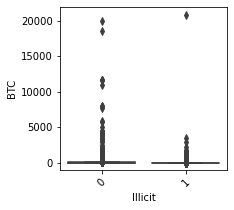

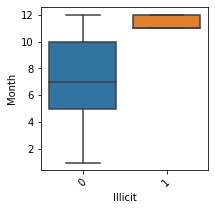

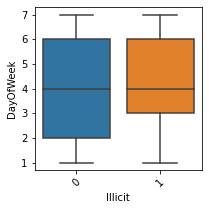

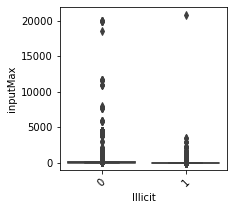

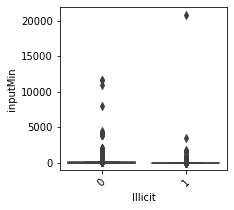

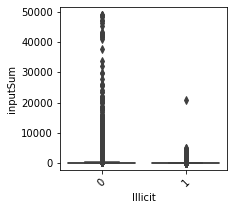

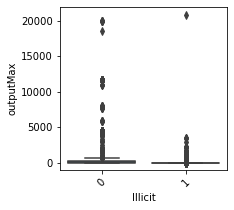

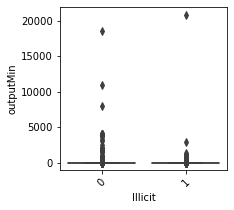

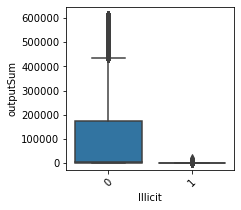

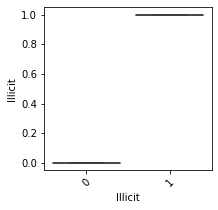

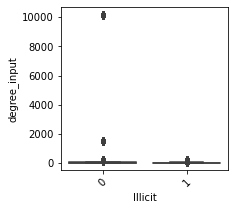

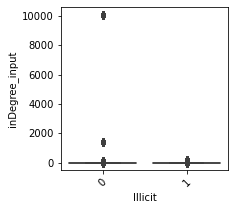

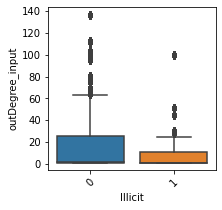

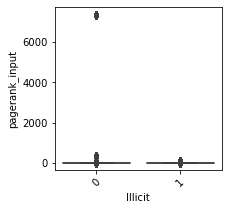

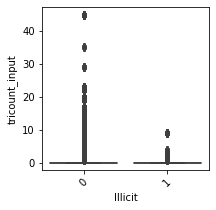

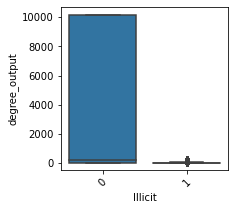

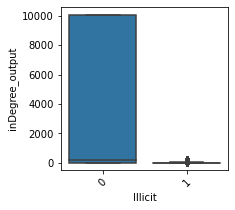

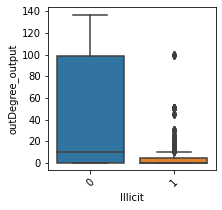

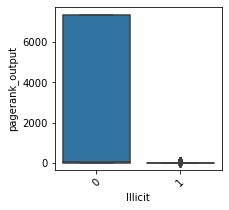

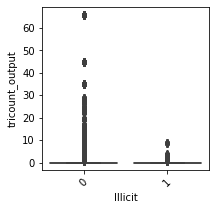

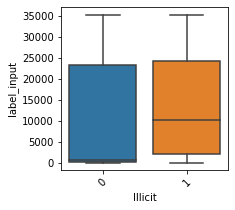

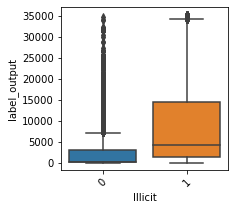

In [33]:
for col in dataset_clean[(dataset_clean.select_dtypes('number').columns)]:
    plt.figure(figsize = (3, 3))
    ax = sns.boxplot(x='Illicit', y=col, data=dataset_clean[(dataset_clean.select_dtypes('number').columns)])
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=45)

In [34]:
dataset_final = dataset_clean[dataset_clean['Illicit']!= 2]
dataset_final['Illicit'] = dataset_final['Illicit'].astype('bool')
dataset_final['Illicit'].value_counts()

False    27825
True     13000
Name: Illicit, dtype: int64

In [35]:
#Split data into variables and test & train
# Removed the wallets from the train set that were in the test set
# stopped data leakage from training set to the test set

to_drop = ['Illicit']

y, x = dataset_final['Illicit'], dataset_final.drop(columns = to_drop)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)

uniq = x_test['InputAddress'].append(x_test['OutputAddress'])
uniq_list = uniq.unique()


x_train_mod = x_train[(x_train['InputAddress'].isin(uniq_list) | x_train['OutputAddress'].isin(uniq_list))==False]
x_train_mod = x_train_mod.drop(columns=['InputAddress','OutputAddress']) #Just put on new line to see whole statement

y_train_mod = y_train[y_train.index.isin(x_train_mod.index)]
x_test_mod = x_test.drop(columns=['InputAddress','OutputAddress'] )



C:\Users\harsmith\AppData\Local\Temp\ipykernel_27620\597184157.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  uniq = x_test['InputAddress'].append(x_test['OutputAddress'])


In [36]:
x_train_mod.shape

(5448, 21)

In [37]:
x_test_mod.shape
# dont do anythin to do this keep it the same as the output from train_test_split

(4083, 21)

# Light GBM Ensemble Model

Fitting 5 folds for each of 4096 candidates, totalling 20480 fits


C:\Users\harsmith\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\harsmith\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\harsmith\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\harsmith\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarni

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
{'bagging_fraction': 1.0, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'feature_fraction': 1.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'learning_rate': 0.08, 'max_bin': 250, 'max_depth': 12, 'metric': 'binary_logloss', 'min_child_samples': 5, 'min_gain_to_split': 0.0, 'n_estimators': 25, 'num_leaves': 64, 'objective': 'bin

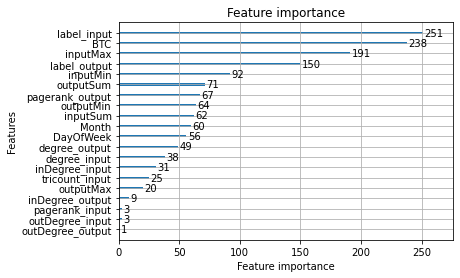

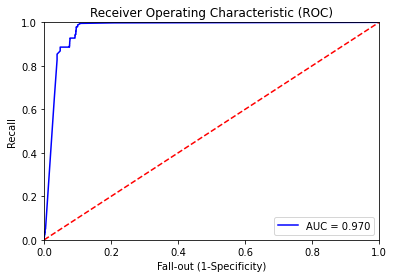

AUC score: 0.9696980292434838


<Figure size 432x288 with 0 Axes>

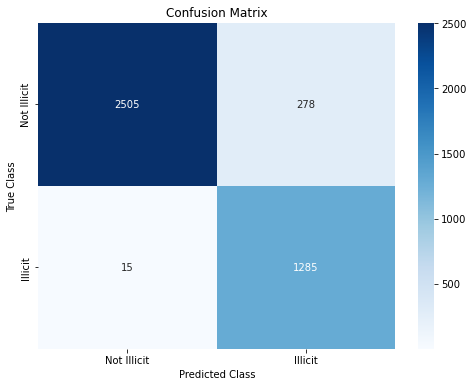

In [38]:
import numpy as np
train_data=lgb.Dataset(x_train_mod, label=y_train_mod)#, categorical_feature=categorical_features)
test_data = lgb.Dataset(x_test_mod, label=y_test)#, categorical_feature=categorical_features)

# to record eval results for plotting
evals_result = {} 

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'is_unbalance': True,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 300,#512
          'metric' : {'binary_logloss'},
          'reg_alpha': .5,
          'reg_lambda': 1.5,
         
        }

# Create parameters to search
gridParams = {
    'learning_rate': [0.01,0.08],
    'n_estimators': [8,25],
    'num_leaves': [30,64],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'num_leaves':[12,64],
    'max_bin': [50,250],
    "max_depth": [3,12],
    'metric' : ['binary_logloss'],
    "min_gain_to_split": [0.0,15.0],
    'lambda_l1': [0.0, 10.0],
    'lambda_l2': [0.0, 10.0],
    'feature_fraction': [0.4, 1.0],
    'bagging_fraction': [0.4, 1.0],
    'bagging_freq': [1,7],
    'min_child_samples': [5,100],
    }

# Create the LGBM Classifier to use in the hyperparameter optimization.
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'])#,
          #reg_alpha = params['reg_alpha'],
          #reg_lambda = params['reg_lambda'])
 

# Show default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, n_jobs=-1,scoring='f1')

# Run the grid
grid_result = grid.fit(x_train_mod, y_train_mod)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Choose grid search CV best hyperparameter values
params['n_estimators'] = grid.best_params_['n_estimators']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['max_bin'] = grid.best_params_['max_bin']
params['max_depth'] = grid.best_params_['max_depth']
params["min_gain_to_split"] =grid.best_params_['min_gain_to_split']
params["lambda_l1"] =grid.best_params_['lambda_l1']
params["lambda_l2"] =grid.best_params_['lambda_l2']
params["feature_fraction"] =grid.best_params_['feature_fraction']
params["bagging_fraction"] =grid.best_params_['bagging_fraction']
params["min_child_samples"] =grid.best_params_['min_child_samples']
#params["min_data_in_leaf"] =grid.best_params_['min_data_in_leaf']


#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']


print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 100,
                 early_stopping_rounds= 40,
                 verbose_eval= 10,
                 
                 valid_sets = [test_data, train_data],
                 evals_result = evals_result)
                 

#Predict on test set
predictions_lgbm_prob = lgbm.predict(x_test_mod)

#Choose optimal threshold that optimizes F1 scores 
f1_score_sweep = [f1_score(y_test, np.where(predictions_lgbm_prob > (thresh*.01), 1, 0)) for thresh in range(100)]
optimal_cutoff = f1_score_sweep.index(max(f1_score_sweep))/100 

predictions_lgbm_01 = np.where(predictions_lgbm_prob > optimal_cutoff, 1, 0) #Turn probability to 0-1 binary output

#--------------------------Output Model Evaluation Metrics----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=20, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(y_test,predictions_lgbm_01)
print('Overall Light GBM model accuracy:', acc_lgbm)

#Plotting Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Showing Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, predictions_lgbm_01)
labels = ['Not Illicit', 'Illicit']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

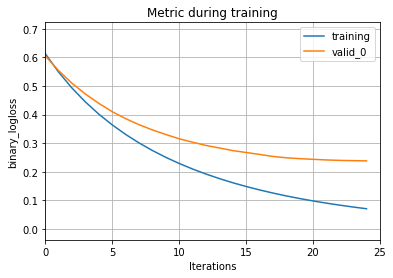

In [39]:
lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_lgbm_01))

              precision    recall  f1-score   support

       False       0.99      0.90      0.94      2783
        True       0.82      0.99      0.90      1300

    accuracy                           0.93      4083
   macro avg       0.91      0.94      0.92      4083
weighted avg       0.94      0.93      0.93      4083



In [41]:
!pip show lightgbm

Name: lightgbm
Version: 3.3.3
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (Microsoft)
Location: c:\users\harsmith\anaconda3\lib\site-packages
Requires: numpy, scipy, scikit-learn, wheel
Required-by: 


In [42]:
lgbm.save_model('Chainalysis_lgb_classifier.txt', num_iteration=lgbm.best_iteration) 

In [43]:
import platform
print(platform.python_version()) 

3.9.12


In [44]:
model = lgb.Booster(model_file='Chainalysis_lgb_classifier.txt')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

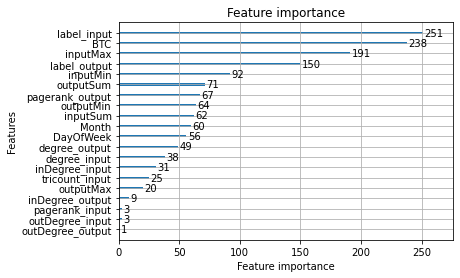

In [45]:
lgb.plot_importance(model, max_num_features=20, importance_type='split')

# Graph Neural Network: Node Classification/Detection Illicit Wallets

Classic Problems in graph NN. 
- Edge Classification
- Node Classification
- Graph Classificiation

If we are working on Node classfication we should probaly focus our graph structure on the output addresses of the wallets inorder to determine which nodes we can classifify as illicit.

In [46]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

In [47]:
kdf

,Month,Day,Time,DayOfWeek,TransactionID,InputAddress,OutputAddress,BTC,Illicit,src,dst,inputMax,inputMin,inputSum,outputMax,outputMin,outputSum
0,7,4,12:04:48,4,0db73422520423519b152bc44824c61faf84088e0bf385...,17Su3J2RWnm2WLqf8pfpgj4hFUf6MFH9SZ,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,0.100000,0,263,24076,200.000000,0.100000,1237.246977,0.100000,0.100000,0.100000
1,7,4,12:04:48,4,0db73422520423519b152bc44824c61faf84088e0bf385...,1K4jCTyKSkATCXB6sXAwN3nkyvQveRMqPZ,111mamKazi1ofZ854rKTcAxhTVuGDPhhL,0.100000,0,741,24076,84.705376,0.100000,694.136401,0.100000,0.100000,0.200000
2,4,16,8:25:51,2,c802582a0acb3c66caa06ce4e767413086a713c732c893...,14aydKbSbRacakgoYzwFkdbLeirJHruiNc,112AYM2ubn4hEdJjb5NGguuEEo6Snp7oBK,0.015600,0,16319,31397,0.015600,0.015600,0.015600,0.015600,0.015600,0.015600
3,11,17,14:24:11,1,6ce024cf19da1ea2d07be757ac87f1edb9e926bd1e76fa...,12szbegicLBGAKaYKDEkxm4WHSV9v1jp5J,112JKu613am7FqJyxycpvcyKbAHgmVugx9,0.004104,1,4102,31732,0.004104,0.004104,0.004104,0.004104,0.004104,0.004104
4,12,9,21:58:17,2,18551dcb848afa5f76ae196074da3b8226674613079827...,1BQ41qwps4v2hJQs9CTLvFs8ZKzf4JqH1B,112Q1Q11rZvbQdo2YCErQMQbLQQ6HJ21jY,0.010276,0,5753,29452,0.188391,0.004923,0.714888,0.010276,0.010276,0.010276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40820,12,19,9:07:59,5,ac91b2407010f3299ba2d8402dae55626628ce2f3c5824...,bc1q2p55hccg33g6v645nspwnayzpcl99jaf3gyfpx2g8l...,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,80.010000,1,2809,1987,80.010000,10.000000,247.241452,80.010000,7.032970,164.856990
40821,12,20,5:34:42,6,4996c8a8714cea6d0e1df9ee9fa8e5ffcee3a515fe35d5...,bc1q2p55hccg33g6v645nspwnayzpcl99jaf3gyfpx2g8l...,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,8.874960,1,2809,1987,80.010000,8.874960,266.116412,80.010000,7.032970,173.731950
40822,12,20,5:34:42,6,4996c8a8714cea6d0e1df9ee9fa8e5ffcee3a515fe35d5...,bc1q2p55hccg33g6v645nspwnayzpcl99jaf3gyfpx2g8l...,bc1qzjeg3h996kw24zrg69nge97fw8jc4v7v7yznftzk06...,10.000000,1,2809,1987,252.871660,8.874960,538.988072,80.010000,7.032970,183.731950
40823,12,1,14:33:17,1,0628c8ae3b05adbf6ff316d351740c19b65968b22a28bf...,3Ao74WwsMpbhJ7pAwkfUxVYYMZSWd9rdYT,bc1qzwr5unft4fkmv0w3xpgj4rdppx56u6ktgttwq0,0.070545,1,1242,34764,1.951387,0.048176,5.264227,0.070545,0.070545,0.070545


In [48]:
df.loc[df["InputAddress"]== unique_ids_list[1]]

,Month,Day,Time,DayOfWeek,TransactionID,InputAddress,OutputAddress,BTC,Illicit,src,dst,inputMax,inputMin,inputSum,outputMax,outputMin,outputSum
40321,12,5,20:35:41,5,081c88ecc74eab23318b7bddec8db4c78429573d4acd57...,3BXMABa8Yxcq9JvPEdizBdbZCvqbMMp6ao,3Qg6fRqQZuH8e2RRwcf6cMHrtkyEBEpfUX,0.002116,1,1,3197,0.002116,0.002116,0.002116,0.319457,0.002116,0.435108


In [49]:
x = pd.Series(df["InputAddress"])

In [50]:
y = pd.Series(df["OutputAddress"])

In [51]:
all_wallets = x.append(y).unique()
all_wallets

C:\Users\harsmith\AppData\Local\Temp\ipykernel_27620\2912760188.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_wallets = x.append(y).unique()


array(['17Su3J2RWnm2WLqf8pfpgj4hFUf6MFH9SZ',
       '1K4jCTyKSkATCXB6sXAwN3nkyvQveRMqPZ',
       '14aydKbSbRacakgoYzwFkdbLeirJHruiNc', ...,
       'bc1qzfw6arlu459az7n03qjucg725d3ge5y9ufvvfm',
       'bc1qzwr5unft4fkmv0w3xpgj4rdppx56u6ktgttwq0',
       'bc1qzxpa9d8adqdut3dfpatmncuda87nfz5tytc89d'], dtype=object)

In [52]:
len(all_wallets)
# Number of wallets in the dataset

35239

So now what I want to do is take the original dataset and for each unique wallet is aggregate the data
- number of transactions
- amount of bit coin sent
- page rank algorithim
- number of connections to other wallets
- numb incomming
- numb outgoing
- difference between those two
- has had illicit transaction
- how many illicit transactions
- traingle coutns
- is it only sending or reciving bitcoin
- largest transaction
- Smallest transaction


In [53]:
wallet_test= kdf.loc[(kdf["InputAddress"] == all_wallets[0]) | (kdf["OutputAddress"] == all_wallets[0])]

In [54]:
features_pandas

,id_output,Unique_ID_output,degree_output,inDegree_output,outDegree_output,pagerank_output,tricount_output,label_output
0,429,35c9y89b3QiY48sfsZ5a3DAkgTcxtgSuWE,1,NaN,1.0,0.450615,0,23399
1,1271,1PyMTMjV3KTn7wFMzSpeztLJSsNF7a4gK5,1,NaN,1.0,0.450615,0,234
2,1650,16RBExMKpEpTFWKZSK6ukFvrceZTRcZ6YG,2,NaN,2.0,0.450615,0,24007
3,2130,15UG9rBZSNJGKWrJvrxYtoLEeLV1b7sy6g,2,NaN,2.0,0.450615,0,24252
4,2183,1NdppVU8tHqYXBBHBwDjdpSMjRh2Uia8uQ,1,NaN,1.0,0.450615,0,234
...,...,...,...,...,...,...,...,...
35234,34297,3D5dnA2YVmvQvNwWgdt4zR1easrjnezEfy,1,1.0,NaN,0.581626,0,440
35235,34447,18QcwvVeT1EkW9omhUWQ5LztzUtNzWASGX,1,1.0,NaN,0.454334,0,29
35236,34675,32dcvtfqTGJ92joYrDEvwnnYfKEnWiXcpn,1,1.0,NaN,1.159208,0,22263
35237,34720,18kSRiLS5hEcsnkJQ8ramgKhJdD3EZn6w8,1,1.0,NaN,0.661223,0,457


In [55]:
def get_data_for_wallet(df):
    
    x = pd.Series(df["InputAddress"])
    y = pd.Series(df["OutputAddress"])
    all_wallets = x.append(y).unique()
    
    new_dataset = pd.DataFrame(columns=["id","Unique_ID","degree","inDegree","outDegree","pagerank","count","label","difference_transactions""has_illicit_trans","number_of_illicit","num_of_BTC",'only_sending','only_recieving',
                               "min_in",'min_out','max_in','max_out'])
    
    print(new_dataset)
    difference_transactions = []
    has_illicit_trans = []
    number_of_illicit = []
    num_of_BTC = []
    only_sending_list = []
    only_recieving_list =[]
    min_in_arr = []
    min_out_arr = []
    max_in_arr = []
    max_out_arr = []
    for wallet in all_wallets:
        wallet_data_sending = kdf.loc[(kdf["OutputAddress"] == wallet)]
        wallet_data_recieving = kdf.loc[(kdf["InputAddress"] == wallet)]
        
        #first is number of transactions involved with 
        num_transactions_sent = wallet_data_sending.shape[0]
        num_transactions_recieved = wallet_data_recieving.shape[0]
        difference = abs(num_transactions_sent-num_transactions_recieved)
        
        #combining data of sent and recieved
        wallet_data_full = pd.concat([wallet_data_recieving,wallet_data_sending])
        
        #if there were any illicit transactions
        if(np.count_nonzero(wallet_data_full["Illicit"])):
            has_illicit = "yes"
        else:
            has_illicit = "no"
        
        #number of illicit transactions
        num_of_illicit = np.count_nonzero(wallet_data_full["Illicit"])
        
        #amount of bitcoin sent
        bit_C_amount = wallet_data_full["BTC"].sum()
        
        # is only recieving
        if num_transactions_sent == 0:
            only_sending = 1
        else:
            only_sending = 0
            
        if num_transactions_recieved == 0:
            only_recieving = 1
        else:
            only_recieving = 0
            
        #min and max transactions
        if num_transactions_recieved == 0:
            min_in = 0
            max_in = 0
        else:
            min_in = min(wallet_data_recieving["BTC"])
            max_in = min(wallet_data_recieving["BTC"])
            
        if num_transactions_sent == 0:
            min_out = 0
            max_out = 0
        else:
            min_out = max(wallet_data_sending["BTC"])
            max_out = max(wallet_data_sending["BTC"])
        
        
        #pandas features already has this info
        #wallet_row = features_pandas.loc[features_pandas["Unique_ID"] == wallet]
        
        #adding to row
        #wallet_row["num_transactions_sent"] = num_transactions_sent
        #wallet_row["num_transactions_recieved"] = num_transactions_recieved
        difference_transactions.append(difference)
        has_illicit_trans.append(has_illicit)
        number_of_illicit.append(num_of_illicit)
        num_of_BTC.append(bit_C_amount)
        only_sending_list.append(only_sending)
        only_recieving_list.append(only_recieving)
        min_in_arr.append(min_in)
        min_out_arr.append(min_out)
        max_in_arr.append(max_in)
        max_out_arr.append(max_out)
        

        #new_dataset = pd.concat([new_dataset,wallet_row])
    #wallet_data = np.array([all_wallets,difference_transactions,has_illicit_trans,number_of_illicit,num_of_BTC,only_sending_list,only_recieving_list,min_in_arr,min_out_arr,max_in_arr,max_out_arr])
    intermitent_data = pd.DataFrame(columns=["Unique_ID","difference_transactions","has_illicit_trans","number_of_illicit","num_of_BTC",'only_sending','only_recieving',
                               "min_in",'min_out','max_in','max_out'])
    intermitent_data["Unique_ID"] = all_wallets
    intermitent_data["difference_transactions"] = difference_transactions
    intermitent_data["has_illicit_trans"] = has_illicit_trans
    intermitent_data["number_of_illicit"] = num_of_illicit
    intermitent_data["number_of_BTC"] = num_of_BTC
    intermitent_data["only_sending"] = only_sending_list
    intermitent_data["only_recieving"] = only_recieving_list
    intermitent_data["min_in"] = min_in_arr
    intermitent_data["min_out"] = min_out_arr
    intermitent_data["max_in"] = max_in_arr
    intermitent_data["max_out"] = max_out_arr                
                               
    new_dataset = features_pandas.merge(intermitent_data,how="left",left_on="Unique_ID_output",right_on = "Unique_ID")

    return new_dataset.fillna(0)
    

In [56]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [57]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='war

In [58]:
#node_features = get_data_for_wallet(kdf)

In [59]:
np.unique(node_features["tricount_output"])

NameError: name 'node_features' is not defined

In [60]:
node_features['has_illicit_trans'].astype('category').cat.codes.to_numpy()

NameError: name 'node_features' is not defined

In [72]:
import dgl
from dgl.data import DGLDataset
import torch
import os

class BlockChainNetwork(DGLDataset):
    def __init__(self):
        super().__init__(name='Bitcoin Tranasactions')

    def process(self):
        node_features = get_data_for_wallet(kdf)
        #node_features = node_features.fillna(0)
        #edges_data = pd.read_csv('./interactions.csv')
        intermitent = node_features['has_illicit_trans'].astype('category').cat.codes.to_numpy()
        node_labels = torch.from_numpy(intermitent)
        node_features = torch.from_numpy(node_features[["id_output","degree_output","inDegree_output",
                                                          "outDegree_output","pagerank_output","tricount_output","label_output",
                                                          "difference_transactions",
                                                          "number_of_illicit","num_of_BTC",'only_sending',
                                                          'only_recieving',"min_in",'min_out','max_in','max_out']].to_numpy())
        
        

        
        print(node_labels.shape)
        print(node_features.shape)
                                                        
        #edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(kdf['src'].to_numpy())
        edges_dst = torch.from_numpy(kdf['dst'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=node_features.shape[0])
        self.graph = dgl.add_self_loop(self.graph)
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        #self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = node_features.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = BlockChainNetwork()
graph = dataset[0]

print(graph)

Empty DataFrame
Columns: [id, Unique_ID, degree, inDegree, outDegree, pagerank, count, label, difference_transactionshas_illicit_trans, number_of_illicit, num_of_BTC, only_sending, only_recieving, min_in, min_out, max_in, max_out]
Index: []
torch.Size([35239])
torch.Size([35239, 16])
Graph(num_nodes=35239, num_edges=76064,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [128]:
"""class NodeClassifier(tf.keras.Model):
    def __init__(self, g, in_feats, h_feats, num_classes):
        super(NodeClassifier, self).__init__()
        self.g = g
        self.conv1 = GraphConv(in_feats, h_feats, activation=tf.nn.relu)
        self.conv2 = GraphConv(h_feats, num_classes)
        
      
    def call(self, in_feat):
        h = self.conv1(self.g, in_feat)
        h = self.conv2(self.g, h)
        return h
    
g = dataset[0]
model = NodeClassifier(
  g, g.ndata["feat"].shape[1], 16, dataset.num_classes)
  """
from dgl.nn import GraphConv
from dgl.nn import SAGEConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats,"pool")
        self.conv2 = SAGEConv(h_feats, num_classes,"pool")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# Create the model with given dimensions
g = dataset[0]
model = GCN(g.ndata["feat"].shape[1], 16, 2)

In [129]:
g.ndata["feat"][0]

tensor([4.2900e+02, 1.0000e+00, 0.0000e+00, 1.0000e+00, 4.5062e-01, 0.0000e+00,
        2.3399e+04, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        6.0000e-04, 0.0000e+00, 6.0000e-04, 0.0000e+00], dtype=torch.float64)

In [137]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata["feat"].long()
    labels = g.ndata["label"].long()
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(1000):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        print(logits.dtype)
        loss = F.cross_entropy(np.squeeze(logits[train_mask]), labels[train_mask])
    
        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print(
                "In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                    e, loss, val_acc, best_val_acc, test_acc, best_test_acc
                )
            )



train(g, model)

RuntimeError: mat1 and mat2 must have the same dtype